# Goodreads Book Reviews

In [1]:
#change display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [3]:
#importing packages
import tqdm
import re
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import pickle

In [4]:
#set directory for loading dataset
DIR = './goodreads-master/'

In [5]:
#function to preview or read in the data the data
#takes each line to a list and then appends to a list to make a list of lists
def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            data_list = []
            data_list.append(d['user_id'])
            data_list.append(d['book_id'])
            data_list.append(d['review_id'])
            data_list.append(d['rating'])
            data_list.append(d['review_text'])
            if r'(view spoiler)' in d['review_text']:
                data_list.append(1)
            else: data_list.append(0)
            data.append(data_list)
            count += 1
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [6]:
#load in raw text (this will probably a little while)
data = load_data(os.path.join(DIR, 'goodreads_reviews_spoiler_raw.json.gz'), head = None)

In [7]:
#take the list of lists to DF

df = pd.DataFrame(data, columns = ['user_id', 'book_id', 'review_id', 'rating', 'review_text', 'spoiler'])
print(df.review_id.nunique())

df.set_index('review_id', inplace = True)
print('')
df.info()


1378033

<class 'pandas.core.frame.DataFrame'>
Index: 1378033 entries, dfdbb7b0eb5a7e4c26d59a937e2e5feb to 62ed1263c7d216986cc419cd4e8a408b
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1378033 non-null  object
 1   book_id      1378033 non-null  object
 2   rating       1378033 non-null  int64 
 3   review_text  1378033 non-null  object
 4   spoiler      1378033 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 63.1+ MB


In [8]:
#remove data from memory
del(data)

## Early Data Exploration

In [9]:
df.rating.value_counts()

4    480199
5    403374
3    290430
2    112226
0     47052
1     44752
Name: rating, dtype: int64

I was not expecting the 0 score for reviews. Let's take a look.

**Not necessary to rerun**

In [10]:
#list of 0 scored reviews
review_text0 = [df.review_text.iloc[i] for i in range(len(df.review_text)) if df.rating.iloc[i] == 0]

In [11]:
#random sample to examine data
np.random.choice(review_text0)

'DNF about 60% \n Boring, wtf writing and unlikable characters.'

Reviews with 0 stars often appear to be from people who did not finish the book or were in the process of reading. However, they can also be legitimate reviews. They are sometimes negative or positive, but are most often neutral. Goodreads allows you to review without setting the stars, so these reviews should likely be thrown out for prediction purposes.

In [12]:
#remove from memory
del(review_text0)

## Data Cleaning

In [10]:
#removing the 0 ratings
df = df.loc[df.rating != 0]
len(df)

1330981

In [11]:
#remove those reviews of under 100 characters for computational speed purposes
df = df.loc[(df.review_text.astype(str).str.len()) >= 100]
len(df)

1175005

In [12]:
#number of unique users
df.user_id.nunique()

18833

In [13]:
#number of unique books
df.book_id.nunique()

25466

In [14]:
#mapping the 5 starts to negative, neutral, positive
df.rating = df.rating.map({1 : -1, 2 : -1, 3 : 0, 4 : 1, 5: 1})
df.rating.value_counts()

 1    771529
 0    261806
-1    141670
Name: rating, dtype: int64

In [15]:
#down sampling the largest class to make it the sum of the size of the other classes; doing this to help simpler models and to help with hardware constraints
df1 = df.loc[df.rating == 1].sample(n = 403476, random_state = 87, axis = 0)
len(df1)

403476

In [16]:
#append the downsampled positive reviews to the new dataframe
df = df.loc[df.rating != 1].append(df1)
len(df)

806952

In [17]:
#removing other df from memory
del(df1)

## Normalization and Preprocessing

In [21]:
#building out a normalization dict to perform prior to stemming
normalization_dict = {'was' : 'be', 'is' : 'be', 'are': 'be', 'been': 'be', 'were': 'be', 'am' : 'be', 
                      'wasnt':'isnt', 'arent':'isnt', 'werent':'isnt', 'does': 'do', 'has': 'have', 'had' : 'have',
                      'so':'', 'such':'', 'the':'', 'a':'', 'an':'', 'to': '', 'of':'', 'in':'', 'on':'', 'all':'', 
                      'for':'', 'about':'', 'at':'', 'that':'', 'this':'', 'probably':'', 'just':'', 'as':'',
                      '1':'one', '2':'two', '3':'three', '4':'four', '5':'five', '6':'six', '7':'seven', '8':'eight', '9':'nine', #numbers 
                      'he':'_pron_', 'she':'_pron_', 'i':'_pron_', 'we':'_pron_', 'you':'_pron_', 'it':'_pron_', 'they':'_pron_', #personal subject pronouns
                      'me':'_pron_', 'us':'_pron_', 'her':'_pron_', 'him':'_pron_', 'them':'_pron_', 'his':'_pron_'} #obj pronouns

In [43]:
#writing a preprocessing and normalization function

from nltk.stem import PorterStemmer
 
# init stemmer
porter_stemmer=PorterStemmer()
 
def basic_preprocessor(text):
    text = re.sub(r"(view spoiler)|(hide spoiler)|\n", "", text) #removing view spoiler, hide spoiler and newline char
    
    text=text.lower() #lower case text
    
    text = re.sub("[^a-z0-9 ]+", "", text) #remove everything except letters and numbers, and spaces (can replace with blank)
    
    #split out words for our list comprehension
    words=re.split("\\s+",text)
    
    #use the normalization words
    normalization_words = [normalization_dict[word] if word in normalization_dict.keys() else word for word in words]
    
    # stem words that aren't blank
    stemmed_words=[porter_stemmer.stem(word=word) for word in normalization_words if word != ""]
        
    return ' '.join(stemmed_words)

**Be careful of processing time below. DO NOT RERUN**

In [24]:
#preprocessing text
df.review_text = [basic_preprocessor(text) for text in df.review_text]

In [45]:
#checking preprocessing
df.review_text[0]

'fun fast pace scienc fiction thriller _pron_ read _pron_ two night and couldnt put _pron_ down book be quantum theori mani world which state decis _pron_ make throughout our live basic creat branch and each possibl path through decis tree can be thought parallel world and book someon invent way switch between these world be nice allud toforeshadow quot _pron_ think choic weve made creat moment _pron_ sit here togeth beauti tabl then _pron_ think possibl event could have stop moment from ever happen and _pron_ feel _pron_ dont know what fragil now _pron_ becom thought moment _pron_ say final it terrifi when _pron_ consid everi thought _pron_ have everi choic _pron_ could possibl make branch into new world book cant be discuss without spoiler _pron_ be book choic and regret ever regret not chase girl your dream _pron_ can focu your career well jason2 made choic and then did regret _pron_ clearli author be tri tell _pron_ optim happi be second rate physic teacher commun colleg if _pron_ 

In [30]:
#pickling the preprocessed text
with open("preprocessed_text.txt", "wb") as fp:   #Pickling
    pickle.dump(list(df.review_text), fp)

In [18]:
#unpickle the preprocessed text list (loading from file)
with open("preprocessed_text.txt", "rb") as fp:   # Unpickling
    df.review_text = pickle.load(fp)

## Splitting Data Prior to Feature Creation/Engineering

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['rating', 'user_id', 'book_id'], axis = 1), 
                                                    df.rating, test_size=0.20, random_state = 43)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(645561, 2) (645561,)
(161391, 2) (161391,)


In [19]:
#remove df from memory
del(df)

In [26]:
#pickling the split data
with open("y_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(y_train, fp)

In [4]:
#unpickle the split data
with open("y_train.pkl", "rb") as fp:   # Unpickling
    y_train = pickle.load(fp)

In [28]:
#pickling the preprocessed text
with open("y_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(y_test, fp)

In [5]:
#unpickle the split data
with open("y_test.pkl", "rb") as fp:   # Unpickling
    y_test = pickle.load(fp)

## CountVectorizer Feature Creation from Text

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_df = 0.20, min_df = 400, ngram_range = (1,2), lowercase = False)

In [40]:
count_vectors_train = count_vectorizer.fit_transform(X_train.review_text)

In [41]:
count_vectors_test = count_vectorizer.transform(X_test.review_text)

In [42]:
len(count_vectorizer.vocabulary_)

34014

In [43]:
#pickling the results
with open("count_vectors_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(count_vectors_train, fp)

In [21]:
#unpickle the results
with open("count_vectors_train.pkl", "rb") as fp:   # Unpickling
    count_vectors_train = pickle.load(fp)

In [44]:
#pickling the results
with open("count_vectors_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(count_vectors_test, fp)

In [22]:
#unpickle the results
with open("count_vectors_test.pkl", "rb") as fp:   # Unpickling
    count_vectors_test = pickle.load(fp)

In [37]:
del(count_vectors_train, count_vectors_test)

## Tfidf Feature Creation from Text

In [38]:
#Count Vectorizer or tfidf_vectorizer?
#I use 20% because only using bigrams due to memory constraints (would use 25 - 30% if included 1-grams)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df = 0.20, min_df = 400, ngram_range = (1,2),
                                  lowercase = False)

In [39]:
tfidf_vectors_train = tfidf_vectorizer.fit_transform(X_train.review_text)

In [40]:
#pickling the results
with open("tfidf_vectors_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(tfidf_vectors_train, fp)

In [6]:
#unpickle the results
with open("tfidf_vectors_train.pkl", "rb") as fp:   # Unpickling
    tfidf_vectors_train = pickle.load(fp)

In [41]:
tfidf_vectors_test = tfidf_vectorizer.transform(X_test.review_text)

In [42]:
#pickling the results
with open("tfidf_vectors_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(tfidf_vectors_test, fp)

In [5]:
#unpickle the results
with open("tfidf_vectors_test.pkl", "rb") as fp:   # Unpickling
    tfidf_vectors_test = pickle.load(fp)

In [43]:
len(tfidf_vectorizer.vocabulary_)

34014

In [44]:
tfidf_vectors_train.shape

(645561, 34014)

In [45]:
#checking if some expected words are in our vocab to deterime if 20% is an OK cutoff for frequency
tfidf_vectorizer.vocabulary_['isnt _pron_']

17193

In [46]:
# print idf values
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights']).iloc[:15]

,idf_weights
happen,2.618200
with _pron_,2.619733
read _pron_,2.640512
review,2.652715
peopl,2.654350
bit,2.658547
thought,2.661651
have be,2.666133
plot,2.666838
felt,2.667413


In [47]:
feature_names = tfidf_vectorizer.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tfidf_vectors_train[0]
 
#print the scores
df1 = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df1.sort_values(by=["tfidf"],ascending=False).head(15)

,tfidf
do take,0.183366
teen,0.182682
sure who,0.180712
feat,0.169914
loveh,0.165187
and experi,0.164603
adult,0.162848
book ill,0.162522
peer,0.162116
take time,0.162000


In [48]:
del(df1)

## Reducing Dimensionality of tfidf

In [49]:
#using truncated SVD to reduce dimensionality further
#truncated SVD can take sparse matricies which is important due to memory constraints
from sklearn.decomposition import TruncatedSVD

#sklearn recommends 100 components for LSA
svd = TruncatedSVD(n_components=300, n_iter=10, random_state=87)

**Be careful of calc time**

In [50]:
SVD_train = svd.fit_transform(X = tfidf_vectors_train, y = y_train)

In [51]:
#pickling the results
with open("SVD_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(SVD_train, fp)

In [5]:
#unpickle the results
with open("SVD_train.pkl", "rb") as fp:   # Unpickling
    SVD_train = pickle.load(fp)

In [52]:
SVD_test = svd.transform(X = tfidf_vectors_test)

In [53]:
#pickling the results
with open("SVD_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(SVD_test, fp)

In [6]:
#unpickle the results
with open("SVD_test.pkl", "rb") as fp:   # Unpickling
    SVD_test = pickle.load(fp)

In [54]:
type(SVD_train)

numpy.ndarray

In [55]:
SVD_train.shape

(645561, 300)

In [84]:
#keeping memory cleared out
del(X_train, X_test, tfidf_vectors_train, tfidf_vectors_test)

## Modeling Sentiment with CountVectorizer Model

### Logistic Regression

#### Count Vectorizer Tuning

In [27]:
from sklearn.linear_model import LogisticRegressionCV
count_cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', solver='lbfgs', max_iter=500, cv = 4, 
                          n_jobs=-1, verbose=1, random_state = 537)

In [28]:
count_logit_model = count_cv.fit(count_vectors_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 81.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 81.7min finished


In [29]:
count_logit_model.scores_

{-1: array([[0.67180946, 0.72278504, 0.73416733, 0.72403666, 0.71508325,
         0.71287123, 0.71280926, 0.71280307],
        [0.670878  , 0.72171758, 0.73331681, 0.72467935, 0.71664911,
         0.71493277, 0.71477787, 0.71477787],
        [0.67062395, 0.72096165, 0.73223868, 0.72286387, 0.71519921,
         0.71340232, 0.71328459, 0.713266  ],
        [0.67172687, 0.72386145, 0.73494021, 0.72476609, 0.71685358,
         0.71506909, 0.71478406, 0.71478406]]),
 0: array([[0.67180946, 0.72278504, 0.73416733, 0.72403666, 0.71508325,
         0.71287123, 0.71280926, 0.71280307],
        [0.670878  , 0.72171758, 0.73331681, 0.72467935, 0.71664911,
         0.71493277, 0.71477787, 0.71477787],
        [0.67062395, 0.72096165, 0.73223868, 0.72286387, 0.71519921,
         0.71340232, 0.71328459, 0.713266  ],
        [0.67172687, 0.72386145, 0.73494021, 0.72476609, 0.71685358,
         0.71506909, 0.71478406, 0.71478406]]),
 1: array([[0.67180946, 0.72278504, 0.73416733, 0.72403666, 0.7150832

Looks like C = 0.01 is the best

In [31]:
from sklearn.linear_model import LogisticRegression

count_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=357, C=0.01, penalty='l2', max_iter=500, n_jobs = -1)

In [32]:
#only using count vector features
model = count_log_reg.fit(count_vectors_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.5min finished


In [33]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
count_preds = model.predict(count_vectors_test)
# Probabilities for each class
count_probs = model.predict_proba(count_vectors_test)[:,]

count_accuracy_score = accuracy_score(y_test, count_preds)
count_f1_value = f1_score(y_test, count_preds, average ='weighted')
count_log_loss_value = log_loss(y_test, base_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(count_accuracy_score))
print("       F-score:     {:0.4f}".format(count_f1_value))
print("      Log Loss:     {:0.4f}".format(count_log_loss_value))

Accuracy Score:     0.7356
       F-score:     0.7300
      Log Loss:     0.6251


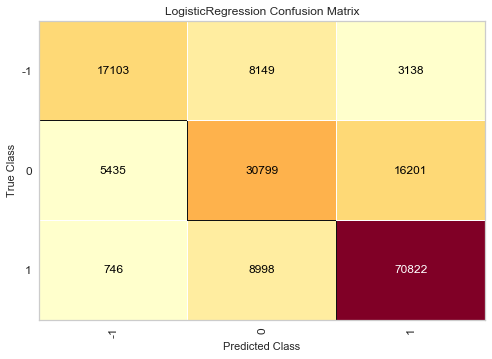

In [35]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(model)

knn_cm.fit(count_vectors_train, y_train)
knn_cm.score(count_vectors_test, y_test)

knn_cm.show()

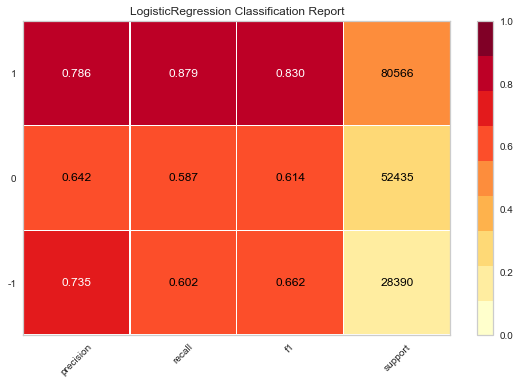

In [36]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(model, support=True)

visualizer.fit(count_vectors_train, y_train)        # Fit the visualizer and the model
visualizer.score(count_vectors_test, y_test)        # Evaluate the model on the test data
visualizer.show()

## Modeling Sentiment with Bag of 2-gram Models

### Logistic Regression

#### Tfidf Features Tuning

In [56]:
from sklearn.linear_model import LogisticRegressionCV
tfidf_cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', solver='lbfgs', max_iter=500, cv = 4, 
                          n_jobs=4, verbose=1, random_state = 53)

In [57]:
tfidf_logit_model = tfidf_cv.fit(tfidf_vectors_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 116.5min remaining: 116.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 117.3min finished


In [58]:
tfidf_logit_model.scores_

{-1: array([[0.50020137, 0.5094522 , 0.67535984, 0.73440898, 0.74058653,
         0.72795881, 0.72233892, 0.72087663],
        [0.50020447, 0.51006878, 0.67436025, 0.73341595, 0.73978561,
         0.72796951, 0.72176715, 0.7208749 ],
        [0.50019828, 0.51018031, 0.67488072, 0.73401078, 0.73918458,
         0.72716401, 0.72105459, 0.71972861],
        [0.50019828, 0.50962885, 0.67756986, 0.73541112, 0.74101865,
         0.72858294, 0.72260983, 0.7220026 ]]),
 0: array([[0.50020137, 0.5094522 , 0.67535984, 0.73440898, 0.74058653,
         0.72795881, 0.72233892, 0.72087663],
        [0.50020447, 0.51006878, 0.67436025, 0.73341595, 0.73978561,
         0.72796951, 0.72176715, 0.7208749 ],
        [0.50019828, 0.51018031, 0.67488072, 0.73401078, 0.73918458,
         0.72716401, 0.72105459, 0.71972861],
        [0.50019828, 0.50962885, 0.67756986, 0.73541112, 0.74101865,
         0.72858294, 0.72260983, 0.7220026 ]]),
 1: array([[0.50020137, 0.5094522 , 0.67535984, 0.73440898, 0.7405865

It appears as though C = 1 is well tuned.

In [60]:
from sklearn.linear_model import LogisticRegression

tfidf_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=357, C=1, penalty='l2', max_iter=500, n_jobs = -1)

In [61]:
#only using tfidf vector features
model = tfidf_log_reg.fit(tfidf_vectors_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 10.0min finished


In [62]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
tfidf_preds = model.predict(tfidf_vectors_test)
# Probabilities for each class
tfidf_probs = model.predict_proba(tfidf_vectors_test)[:,]

tfidf_accuracy_score = accuracy_score(y_test, tfidf_preds)
tfidf_f1_value = f1_score(y_test, tfidf_preds, average ='weighted')
tfidf_log_loss_value = log_loss(y_test, tfidf_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(tfidf_accuracy_score))
print("       F-score:     {:0.4f}".format(tfidf_f1_value))
print("      Log Loss:     {:0.4f}".format(tfidf_log_loss_value))

Accuracy Score:     0.7412
       F-score:     0.7378
      Log Loss:     0.5889


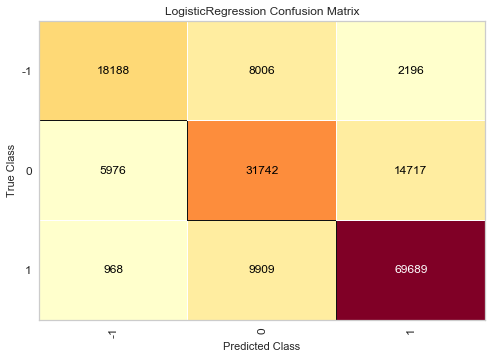

In [63]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(model)

knn_cm.fit(tfidf_vectors_train, y_train)
knn_cm.score(tfidf_vectors_test, y_test)

knn_cm.show()

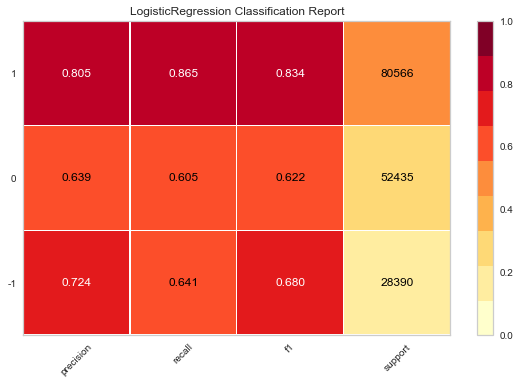

In [65]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(model, support=True)

visualizer.fit(tfidf_vectors_train, y_train)        # Fit the visualizer and the model
visualizer.score(tfidf_vectors_test, y_test)        # Evaluate the model on the test data
visualizer.show()

#### SVD Tuning

In [66]:
from sklearn.linear_model import LogisticRegressionCV
svd_cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', solver='lbfgs', max_iter=500, cv = 4, 
                          n_jobs=-1, verbose=1, random_state = 53)

In [67]:
model = svd_cv.fit(SVD_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 29.5min finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 29.5min remaining:    0.0s


In [70]:
model.scores_

{-1: array([[0.50020137, 0.50935306, 0.65639968, 0.6951317 , 0.69829792,
         0.69876263, 0.69868828, 0.69868828],
        [0.50020447, 0.50991387, 0.65612491, 0.69538385, 0.69845096,
         0.69858727, 0.69868022, 0.69866782],
        [0.50019828, 0.50977756, 0.65622405, 0.69461553, 0.69712498,
         0.69730467, 0.69742859, 0.69743479],
        [0.50019828, 0.5093872 , 0.65904951, 0.69795526, 0.70068158,
         0.70143132, 0.70138175, 0.70138175]]),
 0: array([[0.50020137, 0.50935306, 0.65639968, 0.6951317 , 0.69829792,
         0.69876263, 0.69868828, 0.69868828],
        [0.50020447, 0.50991387, 0.65612491, 0.69538385, 0.69845096,
         0.69858727, 0.69868022, 0.69866782],
        [0.50019828, 0.50977756, 0.65622405, 0.69461553, 0.69712498,
         0.69730467, 0.69742859, 0.69743479],
        [0.50019828, 0.5093872 , 0.65904951, 0.69795526, 0.70068158,
         0.70143132, 0.70138175, 0.70138175]]),
 1: array([[0.50020137, 0.50935306, 0.65639968, 0.6951317 , 0.6982979

The best C = 1000.

In [71]:
#best C was 1000
svd_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=53, C=1000, penalty='l2', max_iter=500, n_jobs = -1)
model = svd_log_reg.fit(SVD_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 19.2min finished


In [72]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
base_preds = model.predict(SVD_test)
# Probabilities for each class
base_probs = model.predict_proba(SVD_test)[:,]

base_accuracy_score = accuracy_score(y_test, base_preds)
base_f1_value = f1_score(y_test, base_preds, average ='weighted')
base_log_loss_value = log_loss(y_test, base_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(base_accuracy_score))
print("       F-score:     {:0.4f}".format(base_f1_value))
print("      Log Loss:     {:0.4f}".format(base_log_loss_value))

Accuracy Score:     0.7001
       F-score:     0.6947
      Log Loss:     0.6700


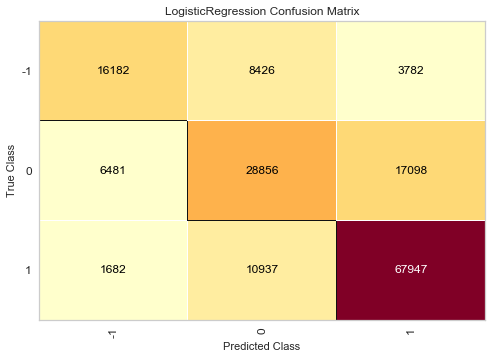

In [73]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(model)

knn_cm.fit(SVD_train, y_train)
knn_cm.score(SVD_test, y_test)

knn_cm.show()

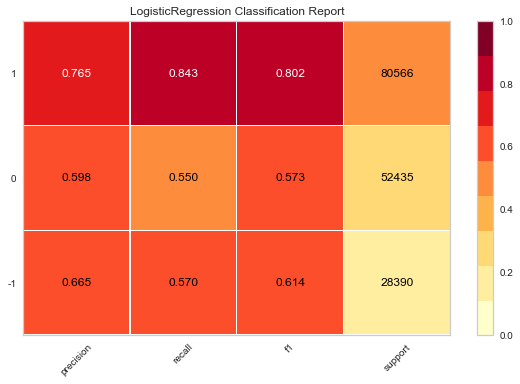

In [74]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(model, support=True)

visualizer.fit(SVD_train, y_train)        # Fit the visualizer and the model
visualizer.score(SVD_test, y_test)        # Evaluate the model on the test data
visualizer.show()



## Doc2Vec

In [18]:
#downloaded pretrained googlenews vectors https://bit.ly/GoogleNews-vectors-negative300 
#from gensim.models.keyedvectors import KeyedVectors
#word_vectors = KeyedVectors.load_word2vec_format('./pretrained/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [29]:
#saving the number of cpus
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [18]:
#importing necessary modules for Doc2Vec
from gensim.models.doc2vec import TaggedDocument, Doc2Vec  
from gensim.utils import simple_preprocess

**Note: the text has not been preprocessed**

### Creating Corpus

In [43]:
#initializing training_corpus
training_corpus = np.empty(len(corpus), dtype=object)
#the text has not yet been preprocessed
print(X_train.review_text[0])

I'm not sure who I would recommend this book to. Teens or adults? The author performs such an amazing feat of capturing high school that several times I was catapulted back into my own school. A crazy trip for any adult! 
 When a teen finishes this book will they be able to look at their peers differently and see a life behind appearances, or does that take time and experience which typically comes with age? I guess either way it doesn't matter. It's such a good 'love/hate' book I'll recommend it to anyone.


In [44]:
#preprocessing text and creating corpus
for i, text in enumerate(X_train.review_text):
    tagged_doc = TaggedDocument(simple_preprocess(text), [i])
    training_corpus[i] = tagged_doc

#clearing out memory before modeling
del(X_train)

In [50]:
#pickling the results
with open("training_corpus.txt", "wb") as fp:   #Pickling
    pickle.dump(training_corpus, fp)

In [6]:
#unpickle the results
with open("training_corpus.txt", "rb") as fp:   # Unpickling
    training_corpus = pickle.load(fp)

### Doc2Vec Modeling

**DO NOT RERUN - CALC TIME**

In [46]:
#creating the model
model = Doc2Vec(size=300, min_count=400, window = 3, workers=num_cores, iter=10)
#building vocab from training_corpus
model.build_vocab(training_corpus)
#training model
model.train(training_corpus, total_examples=model.corpus_count, epochs=model.iter)

In [20]:
#removing training corpus from memory to speed things up
del(training_corpus)

In [51]:
#saving model to disk
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("my_doc2vec_model")
model.save(fname)

In [26]:
#loading model from disk
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("my_doc2vec_model")
model = Doc2Vec.load(fname)

In [62]:
#clearing parts of model from memory once training is finished
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [11]:
len(model.wv.vocab)

11418

### Preprocessing for Utilizing Model

In [19]:
#gensim simple_preprocess on all text
df.review_text = [simple_preprocess(text) for text in df.review_text]

In [22]:
#checking preprocessing
df.review_text[0][0:10]

['fun',
 'fast',
 'paced',
 'science',
 'fiction',
 'thriller',
 'read',
 'it',
 'in',
 'nights']

In [21]:
#pickling the preprocessed text
with open("doc2vec_text.txt", "wb") as fp:   #Pickling
    pickle.dump(list(df.review_text), fp)

In [ ]:
#unpickle the preprocessed text list (loading from file)
with open("doc2vec_text.txt", "rb") as fp:   # Unpickling
    df.review_text = pickle.load(fp)

### Inference using Doc2Vec Model

**Make sure to split text and remove old df**

In [28]:
#create doc2vec vector from the model for X_train
doc2vec_train = [model.infer_vector(text) for text in X_train.review_text]

In [20]:
del(X_train)

In [30]:
#create doc2vec vector from the model for X_test
doc2vec_test = [model.infer_vector(text) for text in X_test.review_text]

In [21]:
del(X_test)

In [32]:
#pickling the doc2vec vector
with open("doc2vec_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(doc2vec_train, fp)

In [6]:
#unpickle the doc2vec vector
with open("doc2vec_train.pkl", "rb") as fp:   # Unpickling
    doc2vec_train = pickle.load(fp)

In [33]:
#pickling the doc2vec vector
with open("doc2vec_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(doc2vec_test, fp)

In [7]:
#unpickle the doc2vec vector
with open("doc2vec_test.pkl", "rb") as fp:   # Unpickling
    doc2vec_test = pickle.load(fp)

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegressionCV
doc2vec_cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000, 10000], penalty='l2', solver='lbfgs', max_iter=500, cv = 4, 
                          n_jobs=-1, verbose=1, random_state = 87)

In [11]:
doc2vec_model = doc2vec_cv.fit(doc2vec_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  8.6min finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  8.6min remaining:    0.0s


In [12]:
doc2vec_model.scores_

{-1: array([[0.63256935, 0.6448315 , 0.6457919 , 0.64602735, 0.64607072,
         0.64607072, 0.64608311, 0.64607692, 0.64608311],
        [0.63127207, 0.6435343 , 0.64487267, 0.64490985, 0.644978  ,
         0.64496561, 0.64497181, 0.64495942, 0.64497181],
        [0.63053473, 0.64278456, 0.6441787 , 0.64432121, 0.64428403,
         0.64427784, 0.64429642, 0.64427784, 0.64429023],
        [0.63258566, 0.64411674, 0.64528781, 0.6454613 , 0.64542413,
         0.64544272, 0.64543032, 0.64544272, 0.64543032]]),
 0: array([[0.63256935, 0.6448315 , 0.6457919 , 0.64602735, 0.64607072,
         0.64607072, 0.64608311, 0.64607692, 0.64608311],
        [0.63127207, 0.6435343 , 0.64487267, 0.64490985, 0.644978  ,
         0.64496561, 0.64497181, 0.64495942, 0.64497181],
        [0.63053473, 0.64278456, 0.6441787 , 0.64432121, 0.64428403,
         0.64427784, 0.64429642, 0.64427784, 0.64429023],
        [0.63258566, 0.64411674, 0.64528781, 0.6454613 , 0.64542413,
         0.64544272, 0.64543032, 

In [13]:
del(doc2vec_model)

The best C = 1, but not iterating much (<50)

In [15]:
#best C was 1
from sklearn.linear_model import LogisticRegression
doc2vec_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=87, C=1, penalty='l2', max_iter=500, n_jobs = -1)
doc2vec_model = doc2vec_log_reg.fit(doc2vec_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.6min finished


In [16]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
doc2vec_preds = doc2vec_model.predict(doc2vec_test)
# Probabilities for each class
doc2vec_probs = doc2vec_model.predict_proba(doc2vec_test)[:,]

doc2vec_accuracy_score = accuracy_score(y_test, doc2vec_preds)
doc2vec_f1_value = f1_score(y_test, doc2vec_preds, average ='weighted')
doc2vec_log_loss_value = log_loss(y_test, doc2vec_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(doc2vec_accuracy_score))
print("       F-score:     {:0.4f}".format(doc2vec_f1_value))
print("      Log Loss:     {:0.4f}".format(doc2vec_log_loss_value))

Accuracy Score:     0.6449
       F-score:     0.6353
      Log Loss:     0.7669


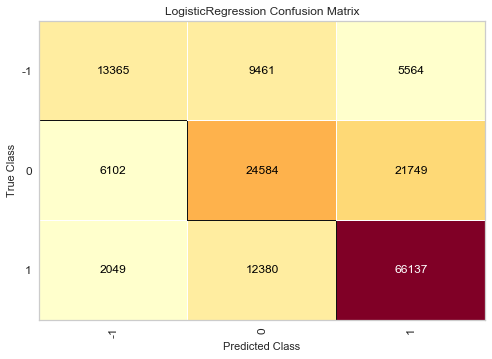

In [17]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(doc2vec_model)

knn_cm.fit(doc2vec_train, y_train)
knn_cm.score(doc2vec_test, y_test)

knn_cm.show()

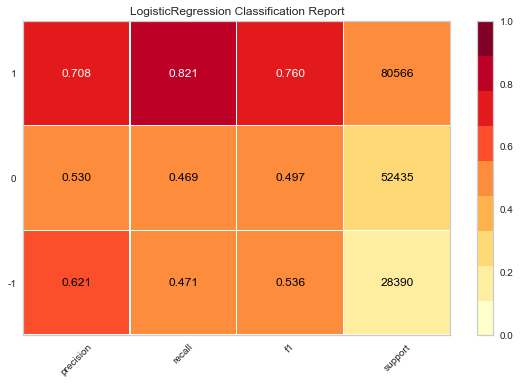

In [18]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(doc2vec_model, support=True)

visualizer.fit(doc2vec_train, y_train)        # Fit the visualizer and the model
visualizer.score(doc2vec_test, y_test)        # Evaluate the model on the test data
visualizer.show()